# Stage 4a — Performance Features (Conditional)

## Purpose

This stage constructs **conditional performance features** — per-90 statistics computed only when the player actually played. These features answer: *"Given that a player participates, how well do they typically perform?"*

The critical insight: **performance features are conditional on participation**. A player's expected points per 90 minutes is undefined if they don't play. This stage explicitly conditions on `minutes > 0` when computing rolling averages.

Coverage is intentionally limited (~58%) because:
- GW 1 has no prior history for anyone
- Players who haven't appeared yet have no performance data
- Rolling windows only include gameweeks where the player actually featured

This stage does NOT impute missing values — missingness is semantically meaningful.

## Inputs & Outputs

| Item | Description |
|------|-------------|
| **Input** | `gameweeks` table from `storage/fpl_2025_26.sqlite` |
| **Output** | `storage/datasets/features_performance.csv` |
| **Produced by** | `dugout.pipeline.features_performance` |
| **Status** | 🔒 Frozen, read-only |

### Features Produced

| Feature | Description |
|---------|-------------|
| `points_per_90_5` | FPL points per 90 mins (rolling 5 appearances) |
| `xGI_per_90_5` | xG + xA per 90 mins (rolling 5 appearances) |
| `bonus_per_90_5` | Bonus points per 90 mins (rolling 5 appearances) |
| `ict_per_90_5` | ICT index per 90 mins (rolling 5 appearances) |

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load frozen artifacts
features = pd.read_csv("../storage/datasets/features_performance.csv")
targets = pd.read_csv("../storage/datasets/targets.csv")

print(f"Rows: {len(features):,}")
print(f"Players: {features['player_id'].nunique()}")
print(f"Gameweeks: {features['gw'].min()} to {features['gw'].max()}")
features.head()

Rows: 16,559
Players: 799
Gameweeks: 1 to 22


,player_id,gw,points_per_90_5,xGI_per_90_5,bonus_per_90_5,ict_per_90_5
0,1,1,NaN,NaN,NaN,NaN
1,1,2,10.0,0.000000,3.00,4.900000
2,1,3,8.0,0.000000,1.50,3.100000
3,1,4,6.0,0.006667,1.00,3.066667
4,1,5,6.0,0.005000,0.75,2.625000


## Structural Sanity Checks

In [6]:
# Row alignment with targets
print(f"Features rows: {len(features):,}")
print(f"Targets rows:  {len(targets):,}")
print(f"Match: {len(features) == len(targets)}")

# Missingness
print("\nMissingness by column:")
miss = features.isna().mean().sort_values(ascending=False)
for col, rate in miss.items():
    print(f"  {col}: {rate:.1%}")

Features rows: 16,559
Targets rows:  16,559
Match: True

Missingness by column:
  points_per_90_5: 44.7%
  xGI_per_90_5: 44.7%
  bonus_per_90_5: 44.7%
  ict_per_90_5: 44.7%
  player_id: 0.0%
  gw: 0.0%


In [7]:
# Why is coverage ~58%?
# Merge with targets to understand
merged = features.merge(targets[["player_id", "gw", "y_play"]], on=["player_id", "gw"])

# Coverage among those who played
played = merged[merged["y_play"] == 1]
played_coverage = played["points_per_90_5"].notna().mean()
print(f"Coverage among y_play==1 rows: {played_coverage:.1%}")

# Coverage among those who didn't play
not_played = merged[merged["y_play"] == 0]
not_played_coverage = not_played["points_per_90_5"].notna().mean()
print(f"Coverage among y_play==0 rows: {not_played_coverage:.1%}")

Coverage among y_play==1 rows: 92.6%
Coverage among y_play==0 rows: 30.1%


## Distribution of Per-90 Features

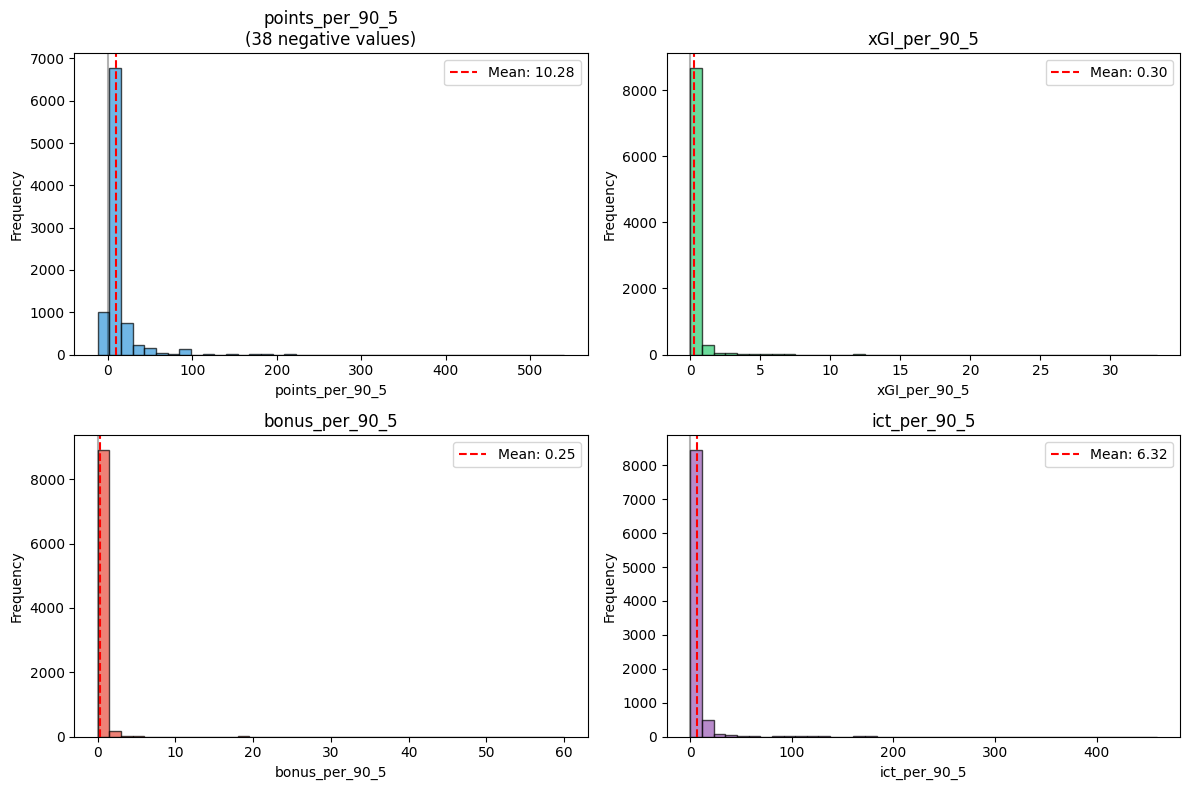

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

feature_cols = ["points_per_90_5", "xGI_per_90_5", "bonus_per_90_5", "ict_per_90_5"]
colors = ["#3498db", "#2ecc71", "#e74c3c", "#9b59b6"]

for ax, col, color in zip(axes.flat, feature_cols, colors):
    valid = features[col].dropna()
    ax.hist(valid, bins=40, edgecolor="black", alpha=0.7, color=color)
    ax.axvline(valid.mean(), color="red", linestyle="--", label=f"Mean: {valid.mean():.2f}")
    ax.axvline(0, color="black", linestyle="-", alpha=0.3)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.legend()
    
    # Show negative count for points_per_90
    if col == "points_per_90_5":
        neg_count = (valid < 0).sum()
        ax.set_title(f"{col}\n({neg_count} negative values)")
    else:
        ax.set_title(col)

plt.tight_layout()
plt.show()

## Interpretation

### Why ~58% Coverage Is Correct

Performance features are **conditional on having prior appearances**. A player needs to have played at least once before we can compute their per-90 stats. This creates intentional missingness:

1. **GW 1**: No one has prior history → 100% missing
2. **First appearance**: No prior performance data → missing
3. **Never played**: Cannot compute per-90 stats → permanently missing

The ~93% coverage among `y_play==1` rows shows that players who actually play usually have prior history.

### Why Per-90 Stats Can Be Negative

`points_per_90_5` can be negative because FPL awards negative points:
- Red card: -3 points
- Own goal: -2 points
- Penalty miss: -2 points
- Goals conceded (GK/DEF): -1 per 2 goals

A goalkeeper who plays 15 minutes, concedes 3 goals, and gets sent off could score -6 points, giving a per-90 of -36. This is rare but valid.

### Conditioning on Appearances Only

The rolling window operates over **appearances**, not gameweeks. If a player plays GW 1, 3, 5, 8, 10:
- Their 5-appearance window at GW 11 includes GWs 1, 3, 5, 8, 10
- GWs 2, 4, 6, 7, 9 are excluded (zero minutes = no performance data)

This prevents dilution by non-appearances and maintains the conditional interpretation.

### Why Missingness Is Not Imputed

Imputing missing performance features would be semantically wrong:
- A new signing with no FPL history has no per-90 stats — that's truth, not a gap to fill
- Imputing with league averages would inject bias

Stage 5 handles this by training conditional models only on rows with valid features.

## What This Stage Enables

With conditional performance features constructed, the pipeline can now:

1. **Model expected points given participation** — separating "how good" from "will they play"
2. **Detect haul potential** — players with high per-90 points are haul candidates
3. **Combine with participation beliefs** — $E[\text{points}] = P(\text{play}) \times E[\text{points} | \text{play}]$

These features feed directly into Stage 5's belief models for `mu_points` and `p_haul`.